In [1]:
import subprocess
import os
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import matplotlib.pyplot as plt
import folium
import branca.colormap as cm
from shapely.ops import unary_union,snap
from shapely.geometry import MultiPolygon, Polygon, GeometryCollection
from rtree import index
import numpy as np
from tqdm import tqdm
from shapely.geometry import MultiLineString, LineString
from itertools import combinations
from geopandas import overlay

In [2]:
def get_git_root():
    try:
        root_dir = (
            subprocess.check_output(["git", "rev-parse", "--show-toplevel"])
            .strip()
            .decode("utf-8")
        )
        return root_dir
    except subprocess.CalledProcessError:
        raise Exception("This is not a Git repository")


# Get the Git repository's root directory
repo_root = get_git_root()
subfolder='data'
file_path = os.path.join(repo_root, subfolder,'GPS','Senegal','2023', "SNGE8RFL.shp")
gps_df=gpd.read_file(file_path)

In [3]:
###Calculate the wealth index average for each cluster with weights based on the household sample weight
household_wealth_index_df=pd.read_csv(os.path.join(repo_root, "Wealth_Index_DF.csv"))
def weighted_average(values, weights):
    return np.average(values, weights=weights) 

cluster_wealth=household_wealth_index_df.groupby('hv001').apply(
    lambda x:pd.Series({'wealth_index':weighted_average(x['wealth_index'],x['hv005'])})
).reset_index()

C:\Users\worbo\AppData\Local\Temp\ipykernel_25720\1627577868.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_wealth=household_wealth_index_df.groupby('hv001').apply(


In [4]:
gps_dfmerged=pd.merge(gps_df, cluster_wealth,left_on='DHSCLUST',right_on='hv001',how='right') #Adding the wealth index to the gps data


In [5]:
senegal_filepath=os.path.join(repo_root, subfolder,'ShapeFiles','Senegal_Shapefile', "gadm41_SEN_0.shp")
senegal_boundary=gpd.read_file(senegal_filepath)

In [6]:
###Creating the geometry and the dataframe that includes the geometry
geometry=[Point(xy) for xy in zip(gps_dfmerged['LONGNUM'],gps_dfmerged['LATNUM'])]
gdf=gpd.GeoDataFrame(gps_dfmerged,geometry=geometry)
senegal_boundary = senegal_boundary.to_crs(gdf.crs)
gdf = gdf.to_crs(epsg=32628)###Converting to UTM for buffer creation

###adding a buffer based on ubran or rural
def create_errorbounds(row):
    if row["URBAN_RURA"]=='U':
        return row['geometry'].buffer(2000)
    elif row["URBAN_RURA"]=='R':
        return row['geometry'].buffer(5050)
    else:
        print(f"Error, can't determine urban or rural for row {row}. Exiting")
        exit()

gdf['buffer']=gdf.apply(create_errorbounds,axis=1)
buffer_gdf = gpd.GeoDataFrame(gdf[["buffer"]], geometry="buffer", crs="EPSG:32628")
buffer_gdf = buffer_gdf.to_crs(epsg=4326)
gdf["buffer"] = buffer_gdf["buffer"]
gdf['buffer']=gdf['buffer'].to_crs(epsg=4326)###Converting back to WGS84 for plotting
gdf = gdf.to_crs(epsg=4326)###Converting back to WGS84 for plotting

###Clipping the buffer to the Senegal boundary
gdf_clipped=gdf['buffer'].clip(senegal_boundary)
gdf['buffer']=gdf_clipped
###For overlapping regions, averaging the wealth index
gdf['wealth_index']=gdf.groupby('buffer')['wealth_index'].transform('mean')
gdf = gdf.drop(columns=["geometry"])
# Drop duplicates in household_wealth_index to ensure each hv001 has only one hv005
household_wealth_index_unique = household_wealth_index_df[['hv001', 'hv005']].drop_duplicates(subset='hv001')

# Merge the DataFrames on the matching columns
merged_df = gdf.merge(household_wealth_index_unique, left_on='DHSCLUST', right_on='hv001', how='left')

# Update the hv005 column in gdf with the corresponding values from household_wealth_index
gdf['hv005'] = merged_df['hv005']

# Drop the extra columns added during the merge
gdf.drop(columns=['hv001'], inplace=True)
gdf.set_geometry("buffer", inplace=True)

In [7]:

gdf=gdf[['wealth_index','hv005','buffer']]

In [8]:
gdf.explode(ignore_index=True)

AttributeError: 'NoneType' object has no attribute 'copy'

,wealth_index,hv005,buffer
0,2.232355,1308253.0,"POLYGON ((-17.42182 14.70521, -17.42241 14.703..."
1,2.386455,3751585.0,"POLYGON ((-17.44447 14.7136, -17.44471 14.7118..."
2,3.693377,1428023.0,"POLYGON ((-17.42532 14.69815, -17.42556 14.696..."
3,3.693377,1428023.0,"POLYGON ((-17.43188 14.68589, -17.43292 14.685..."
4,2.020022,2489214.0,"POLYGON ((-17.42907 14.72319, -17.42932 14.721..."
...,...,...,...
398,-1.690666,381835.0,"POLYGON ((-15.54206 12.80456, -15.54272 12.800..."
399,-1.519875,441155.0,"POLYGON ((-15.34247 12.8442, -15.34314 12.8397..."
400,-1.703344,524930.0,"POLYGON ((-15.89758 12.71151, -15.89823 12.707..."
401,-1.861959,423330.0,"POLYGON ((-15.73536 12.9117, -15.73602 12.9072..."


In [9]:
gdf["geometry"] = gdf["buffer"]
gdf = gdf.drop(columns=["buffer"])
gdf.set_geometry("geometry", inplace=True)

In [35]:
###TODO: Ensure this is correctly handling multiple overlaps

In [10]:
gdf = gdf.to_crs(epsg=32628)

In [11]:
senegal_boundary=senegal_boundary.to_crs(epsg=32628)

In [ ]:
import numpy as np
from shapely.geometry import box
from shapely.ops import unary_union
from shapely import prepare, intersects
import geopandas as gpd
import pandas as pd
from tqdm import tqdm


def calculate_weighted_average(intersections):
    """
    Calculate double-weighted average using vectorized operations.
    """
    areas = intersections["intersection_area"].values
    hv005 = intersections["hv005"].values
    wealth_indices = intersections["wealth_index"].values

    area_weights = areas / np.sum(areas)
    hv005_weights = hv005 / np.sum(hv005)
    combined_weights = area_weights * hv005_weights
    combined_weights /= np.sum(combined_weights)

    return np.sum(wealth_indices * combined_weights)


def create_grid(shapefile, wealth_df, cell_size=500):
    """
    Create grid, process intersections, and calculate wealth indices.
    Optimized for performance using spatial indexing and vectorized operations.
    """
    print("Creating grid...")

    # Get bounds and create unified shape
    bounds = shapefile.total_bounds
    unified_shape = unary_union(shapefile.geometry)
    prepare(unified_shape)  # Prepare geometry for faster intersection tests

    # Calculate grid dimensions
    xmin, ymin, xmax, ymax = [
        np.floor(bounds[0] / cell_size) * cell_size,
        np.floor(bounds[1] / cell_size) * cell_size,
        np.ceil(bounds[2] / cell_size) * cell_size,
        np.ceil(bounds[3] / cell_size) * cell_size,
    ]

    # Create vectorized coordinates
    x_coords = np.arange(xmin, xmax + cell_size, cell_size)
    y_coords = np.arange(ymin, ymax + cell_size, cell_size)
    xx, yy = np.meshgrid(x_coords, y_coords)

    print(
        f"Grid dimensions: {len(x_coords)}x{len(y_coords)} = {len(x_coords)*len(y_coords)} cells"
    )

    # Create grid cells efficiently
    grid_cells = []
    with tqdm(total=len(xx.flat), desc="Processing grid cells") as pbar:
        for x, y in zip(xx.flat, yy.flat):
            cell = box(x, y, x + cell_size, y + cell_size)
            if intersects(cell, unified_shape):
                grid_cells.append(cell)
            pbar.update(1)

    print(f"Found {len(grid_cells)} intersecting cells")

    # Create initial grid GeoDataFrame
    grid = gpd.GeoDataFrame(geometry=grid_cells, crs=shapefile.crs)

    # Ensure matching CRS
    if wealth_df.crs != grid.crs:
        wealth_df = wealth_df.to_crs(grid.crs)

    # Create spatial index for wealth data
    wealth_sindex = wealth_df.sindex
    wealth_union = unary_union(wealth_df.geometry)
    prepare(wealth_union)

    # Process intersections and calculate wealth values
    results = []
    with tqdm(total=len(grid), desc="Calculating wealth indices") as pbar:
        for idx, cell_geom in grid.geometry.items():
            # Quick intersection check
            if not intersects(cell_geom, wealth_union):
                continue

            # Use spatial index to find potential intersections
            possible_matches_idx = list(wealth_sindex.intersection(cell_geom.bounds))
            if not possible_matches_idx:
                continue

            # Get actual intersections
            matches = wealth_df.iloc[possible_matches_idx]
            intersecting = matches[matches.geometry.intersects(cell_geom)]

            if len(intersecting) == 0:
                continue

            # Calculate intersection areas
            intersection_areas = intersecting.geometry.apply(
                lambda x: x.intersection(cell_geom).area
            )

            # Create intersection DataFrame
            intersections_df = pd.DataFrame(
                {
                    "hv005": intersecting["hv005"].values,
                    "wealth_index": intersecting["wealth_index"].values,
                    "intersection_area": intersection_areas.values,
                }
            )

            # Calculate wealth value
            value = (
                intersections_df["wealth_index"].iloc[0]
                if len(intersections_df) == 1
                else calculate_weighted_average(intersections_df)
            )

            # Clip geometry to wealth area
            clipped_geom = cell_geom.intersection(wealth_union)
            if not clipped_geom.is_empty:
                results.append({"geometry": clipped_geom, "wealth_index": value})

            pbar.update(1)

    # Create final GeoDataFrame
    final_grid = gpd.GeoDataFrame(results, crs=grid.crs)
    print(f"Final grid contains {len(final_grid)} cells")

    return final_grid


def main(shapefile_path, wealth_df_path, cell_size=500):
    """
    Main processing function.
    """
    print("Reading input files...")
    shapefile = shapefile_path
    wealth_df = wealth_df_path

    result = create_grid(shapefile, wealth_df, cell_size)
    return result

result = main(senegal_boundary, gdf, cell_size=500)


Reading input files...
Creating grid...
Grid dimensions: 1344x968 = 1300992 cells


Processing grid cells: 100%|██████████| 1300992/1300992 [10:28<00:00, 2068.36it/s]


Found 791464 intersecting cells


Calculating wealth indices:  10%|▉         | 75946/791464 [04:24<41:30, 287.25it/s]  
C:\Users\worbo\AppData\Local\Temp\ipykernel_25720\4107464473.py:145: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  result.to_file("output_grid.shp")


Final grid contains 75946 cells


c:\Users\worbo\anaconda3\envs\py12.7seminar\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'wealth_index' to 'wealth_ind'
  ogr_write(


In [20]:
result.to_file(os.path.join(repo_root,"data",'Results','GPSResults','output.gpkg'),driver="GPKG")

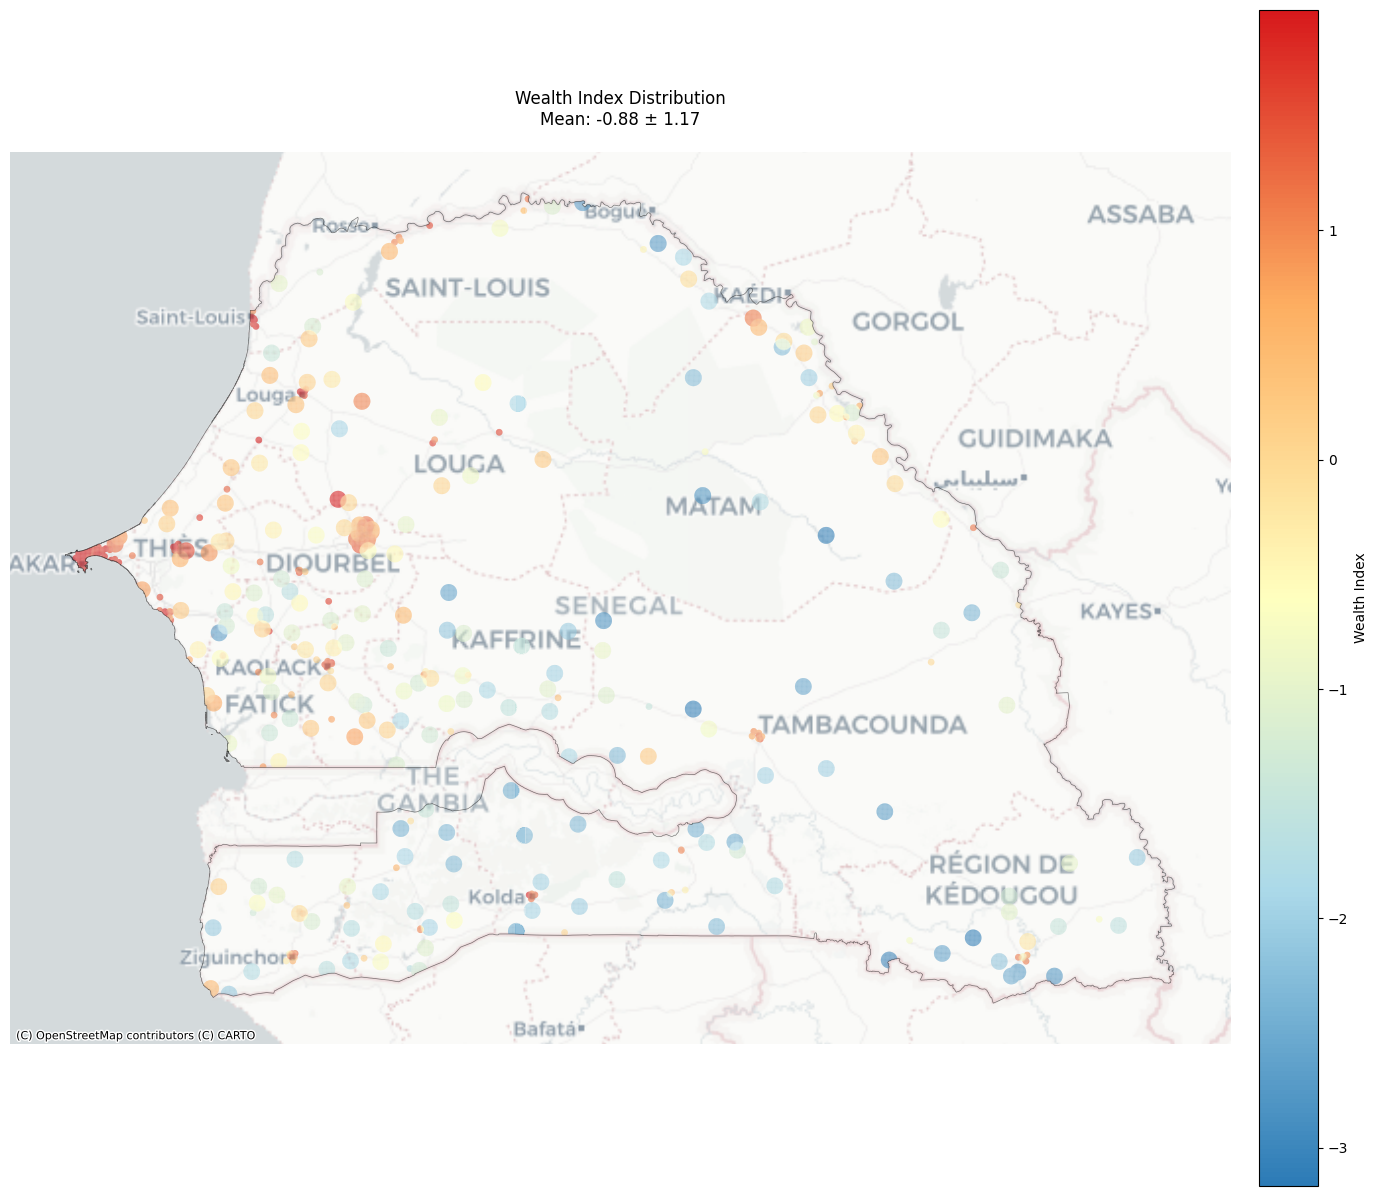

In [ ]:
import matplotlib.pyplot as plt
import contextily as ctx
from matplotlib.colors import LinearSegmentedColormap


def plot_wealth_heatmap(
    result_grid, original_shapefile, output_path=None, figsize=(15, 15), dpi=300,epsg="EPSG:3857"
):
    """
    Create a professional heatmap visualization of wealth index values.

    Parameters:
    -----------
    result_grid : GeoDataFrame
        The processed grid with wealth_index values
    original_shapefile : GeoDataFrame
        The original shapefile for background context
    output_path : str, optional
        Path to save the figure. If None, displays the plot instead
    figsize : tuple, default (15, 15)
        Size of the output figure in inches
    dpi : int, default 300
        Resolution of the output figure
    """
    # Convert to Web Mercator for basemap compatibility
    if result_grid.crs != epsg:
        result_grid = result_grid.to_crs(epsg)
    if original_shapefile.crs != epsg:
        original_shapefile = original_shapefile.to_crs(epsg)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)

    # Calculate wealth index statistics for optimal color mapping
    wealth_values = result_grid["wealth_index"]
    vmin, vmax = wealth_values.quantile([0.01, 0.99])  # Remove outliers

    # Create custom colormap for better visualization
    colors = ["#d7191c", "#fdae61", "#ffffbf", "#abd9e9", "#2c7bb6"]
    colors=colors[::-1]
    custom_cmap = LinearSegmentedColormap.from_list("custom", colors)

    # Plot original shapefile boundaries
    original_shapefile.boundary.plot(ax=ax, color="black", linewidth=0.5, alpha=0.5)

    # Plot heatmap with optimized settings
    result_grid.plot(
        column="wealth_index",
        ax=ax,
        cmap=custom_cmap,
        vmin=vmin,
        vmax=vmax,
        alpha=0.7,
        legend=True,
        legend_kwds={
            "label": "Wealth Index",
            "orientation": "vertical",
            "shrink": 0.8,
            "pad": 0.02,
        },
    )

    # Add basemap for context
    try:
        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    except Exception as e:
        print(f"Warning: Could not add basemap: {e}")

    # Optimize plot appearance
    ax.set_axis_off()
    plt.tight_layout()

    # Add title with statistics
    mean_wealth = wealth_values.mean()
    std_wealth = wealth_values.std()
    plt.title(
        f"Wealth Index Distribution\n" f"Mean: {mean_wealth:.2f} ± {std_wealth:.2f}",
        pad=20,
    )

    # Save or display the plot
    if output_path:
        plt.savefig(output_path, dpi=dpi, bbox_inches="tight", pad_inches=0.1)
        plt.close()
    else:
        plt.show()


plot_wealth_heatmap(
        result, senegal_boundary
    )